### Hugging Face Distilbert Transfer Learning - Only Architecture
This model is just for demonstration purposes. Obviously not proper for the given task.
It would be like killing a fly with an elephant gun!
y transformation is applied to entire set. No good results anyway!

In [1]:
import pandas as pd
import numpy as np 
import pickle
import time
from datetime import datetime
import sys

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import transformers

import matplotlib.pyplot as plt
import seaborn as sns

print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

# from utils import * 
# del sys.modules['utils']
# from utils import * 

Version:  2.4.1
GPU is available


In [2]:
df = pd.read_csv("./data/df_slow.csv")
df.shape
summary = df["query_time_ns"]\
    .describe(percentiles=[0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99, 1.00])
mask = (df["query_time_ns"]<summary["99%"])
sum(mask)
#%%
df = df[mask]
m = df['query_time_ns'].mean()
s = df['query_time_ns'].std()

y = (df['query_time_ns']-m)/s
#%%
X = df['clean_query']
X.shape, y.shape

((15375,), (15375,))

In [3]:
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, test_size=0.3)
xvalid, xtest, yvalid, ytest = train_test_split(xvalid, yvalid, test_size=0.3)
xtrain.shape, xvalid.shape, xtest.shape, ytrain.shape, yvalid.shape, ytest.shape

((10762,), (3229,), (1384,), (10762,), (3229,), (1384,))

In [4]:
# Model constants.
max_features = 1000
# embedding_dim = 200
sequence_length = 128
batch_size = 2

model_name = "distilbert-base-uncased"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [5]:
class BertSemanticDataGenerator(tf.keras.utils.Sequence):
    """Generates batches of data.

    Args:
        excerpt : Array of premise and hypothesis input sentences.
        target: Array of target.
        batch_size: Integer batch size.
        shuffle: boolean, whether to shuffle the data.
        include_targets: boolean, whether to incude the target.

    Returns:
        Tuples `([input_ids, attention_mask, `token_type_ids], target)`
        (or just `[input_ids, attention_mask, `token_type_ids]`
         if `include_targets=False`)
    """

    def __init__(
        self,
        excerpt,
        target,
        batch_size,
        tokenizer,
        max_length,
        shuffle=False,
        include_targets=False,
    ):
        self.excerpt = excerpt
        self.target = target
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.include_targets = include_targets
        # Load our BERT Tokenizer to encode the text.
        # We will use base-base-uncased pretrained model.
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.indexes = np.arange(len(self.excerpt))
        self.on_epoch_end()
    
    def __len__(self):
        # Denotes the number of batches per epoch.
        return len(self.excerpt) // self.batch_size
    def __getitem__(self, idx):
        # Retrieves the batch of index.
        indexes = self.indexes[idx * self.batch_size : (idx + 1) * self.batch_size]
        excerpt = self.excerpt[indexes]
        encoded = self.tokenizer.batch_encode_plus(
                    [t[0] for t in excerpt.tolist()],
                    add_special_tokens=True,
                    truncation=True,
                    max_length=self.max_length,
                    return_attention_mask=True,
                    return_token_type_ids=True,
                    pad_to_max_length=True,
                    return_tensors="tf",
                )
        # Convert batch of encoded features to numpy array.
        input_ids = np.array(encoded["input_ids"], dtype="int32")
        attention_masks = np.array(encoded["attention_mask"], dtype="int32")
        output = [input_ids, attention_masks] #, token_type_ids]
        if self.include_targets:
            target = np.array(self.target.iloc[indexes], dtype="float")
            return output, target
        else:
            return output   
        
    def on_epoch_end(self):
        # Shuffle indexes after each epoch if shuffle is set to True.
        if self.shuffle:
            np.random.RandomState(42).shuffle(self.indexes)

In [6]:
train_data = BertSemanticDataGenerator(
    xtrain.values.astype("str"),
    ytrain,
    batch_size=batch_size,
    tokenizer=tokenizer,
    max_length=sequence_length,
    shuffle=True,
    include_targets=True,
)
#%%
val_data = BertSemanticDataGenerator(
    xvalid.values.astype("str"),
    yvalid,
    batch_size=batch_size,
    tokenizer=tokenizer,
    max_length=sequence_length,
    shuffle=True,
    include_targets=True,
)
# %%
# sample = next(iter(val_data))
# sample

In [7]:
checkpoint_filepath = "./tmp/checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=checkpoint_filepath,
                        save_weights_only=True,
                        monitor='val_r_square',
                        mode='min',
                        save_best_only=True,
                        )   
def scheduler(epoch, lr):
    return lr * 0.8**epoch 

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_r_square', 
                                patience=3,
                                restore_best_weights=True)
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
callbacks = [
    tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1),
    checkpoint_callback,
    early_stopping,
    tb_callback,
]

In [8]:
tf.keras.backend.clear_session()
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():

    input_ids = tf.keras.layers.Input(
        shape=(sequence_length,), dtype=tf.int32, name="input_ids"
    )
    attention_masks = tf.keras.layers.Input(
        shape=(sequence_length,), dtype=tf.int32, name="attention_masks"
    )
    
    bert_model = transformers.TFAutoModelForSequenceClassification.from_pretrained(model_name)
    bert_model.trainable = True

    sequence_output = bert_model.distilbert(
        input_ids, attention_mask=attention_masks, 
    )[0]
    x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
    
    output = tf.keras.layers.Dense(1)(x)
    model = tf.keras.models.Model(
        inputs=[input_ids, attention_masks], 
        outputs=output
    )

    model.compile(
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError(),
                 tf.keras.metrics.MeanAbsoluteError(),
                 tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        )
print(f"Strategy: {strategy}")
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_transform', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier', 'pre_classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [9]:
epochs = 3
history = model.fit(train_data, 
            validation_data=val_data,
            epochs=epochs, 
            batch_size=batch_size,
            callbacks=callbacks)


Epoch 1/3


C:\ProgramData\Anaconda3\envs\x_env_con\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(



Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
5381/5381 [==============================] - 798s 147ms/step - loss: 1.0268 - root_mean_squared_error: 1.0124 - mean_absolute_error: 0.7391 - r_square: -0.1046 - val_loss: 0.9584 - val_root_mean_squared_error: 0.9790 - val_mean_absolute_error: 0.7223 - val_r_square: -3.2544e-05
Epoch 2/3

Epoch 00002: LearningRateScheduler reducing learning rate to 7.999999797903001e-05.
5381/5381 [==============================] - 793s 147ms/step - loss: 1.0693 - root_mean_squared_error: 1.0332 - mean_absolute_error: 0.7718 - r_square: -0.0145 - val_loss: 0.9588 - val_root_mean_squared_error: 0.9792 - val_mean_absolute_error: 0.7072 - val_r_square: -0.0013
Epoch 3/3

Epoch 00003: LearningRateScheduler reducing learning rate to 5.119999870657922e-05.
5381/5381 [==============================] - 792s 147ms/step - loss: 0.9896 - root_mean_squared_error: 0.9940 - mean_absolute_error: 0.7333 - r_square: -0.0055 - val_loss:

In [10]:
# Epoch 1/3

# Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
# INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
# INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
# 5381/5381 [==============================] - 2116s 391ms/step - loss: 1.1447 - root_mean_squared_error: 1.0669 - val_loss: 1.0648 - val_root_mean_squared_error: 1.0319
# Epoch 2/3

# Epoch 00002: LearningRateScheduler reducing learning rate to 7.999999797903001e-05.
# 5381/5381 [==============================] - 1042s 194ms/step - loss: 0.9976 - root_mean_squared_error: 0.9984 - val_loss: 1.0351 - val_root_mean_squared_error: 1.0174
# Epoch 3/3

# Epoch 00003: LearningRateScheduler reducing learning rate to 5.119999870657922e-05.
# 5381/5381 [==============================] - 1049s 195ms/step - loss: 1.0270 - root_mean_squared_error: 1.0132 - val_loss: 1.0688 - val_root_mean_squared_error: 1.0338

In [11]:
# 1061 + 1051 + 1056

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [13]:
def eval_model(model, x, y, data_type):
    start = time.time()
    pred = model.predict(x)
    pred_time = np.round((time.time() - start),4)
    print(f"{data_type} - Root mean squared error     : {(mean_squared_error(y, pred, squared=False)):.2f}")
    print(f"{data_type} - Mean absolute error         : {(mean_absolute_error(y, pred)):.2f}")
    print(f"{data_type} - Coefficient of determination: {(r2_score(y, pred)):.2f}")
    print(f"{data_type} - Time elapsed                : {pred_time}\n")
    return mean_squared_error(y, pred, squared=False), mean_absolute_error(y, pred), r2_score(y, pred), pred_time


In [14]:
model_name = "keras_distil_bert"
model_path = "./models/" + model_name
model.save(model_path)
# model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: ./models/keras_distil_bert\assets


INFO:tensorflow:Assets written to: ./models/keras_distil_bert\assets


In [15]:
from pathlib import Path
model_directory = Path(model_path)
model_size = sum(f.stat().st_size for f in model_directory.glob('**/*') if f.is_file())

In [16]:
# shuffle=False and batch size = 1 for evaluation
batch_size = 1
train_data = BertSemanticDataGenerator(
    xtrain.values.astype("str"),
    ytrain,
    batch_size=batch_size,
    tokenizer=tokenizer,
    max_length=sequence_length,
    shuffle=False,
    include_targets=True,
)
#%%
val_data = BertSemanticDataGenerator(
    xvalid.values.astype("str"),
    yvalid,
    batch_size=batch_size,
    tokenizer=tokenizer,
    max_length=sequence_length,
    shuffle=False,
    include_targets=True,
)
# %%
# sample = next(iter(val_data))
# sample

In [17]:
batch_size = 1
y_test_psuedo = 0
test_data = BertSemanticDataGenerator(
    xtest.values.astype("str"),
    y_test_psuedo,
    batch_size=batch_size,
    tokenizer=tokenizer,
    max_length=sequence_length,
    shuffle=False,
    include_targets=False,
)

In [18]:
print(f"model size                         : {model_size}")

model size                         : 800626249


In [19]:
tr_rmse, tr_mae, tr_r2, tr_time_elapsed  = eval_model(model, train_data, ytrain, data_type="Train")

C:\ProgramData\Anaconda3\envs\x_env_con\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train - Root mean squared error     : 1.01
Train - Mean absolute error         : 0.82
Train - Coefficient of determination: -0.02
Train - Time elapsed                : 286.7872



In [20]:
val_rmse, val_mae, val_r2, val_time_elapsed  = eval_model(model, val_data, yvalid, data_type="Valid")

C:\ProgramData\Anaconda3\envs\x_env_con\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Valid - Root mean squared error     : 0.99
Valid - Mean absolute error         : 0.80
Valid - Coefficient of determination: -0.02
Valid - Time elapsed                : 87.5075



In [21]:
test_rmse, test_mae, test_r2, test_time_elapsed  = eval_model(model, test_data, ytest, data_type="Test")

C:\ProgramData\Anaconda3\envs\x_env_con\lib\site-packages\transformers\tokenization_utils_base.py:2104: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Test - Root mean squared error     : 1.01
Test - Mean absolute error         : 0.82
Test - Coefficient of determination: -0.01
Test - Time elapsed                : 38.823



In [22]:
df_performance = pd.read_csv("./data/df_performance.csv")
df_performance.set_index("Model", inplace=True)
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.6,38663.8,0.98,0.0016,143922.3,51397.7,0.97,0.0000,138415.1,52290.4,0.97,0.0000
svc_regr,7579.0,888415.7,422135.8,-0.29,0.0015,881327.0,428619.1,-0.31,0.0000,910742.5,446665.0,-0.31,0.0000
rand_for_reg,24770494.0,67211.8,20448.7,0.99,0.1519,134162.6,39441.2,0.97,0.0616,138995.7,42581.3,0.97,0.0275
ada_boost_reg,36763.0,219145.3,160038.5,0.92,0.0286,221945.0,161057.6,0.92,0.0103,231910.7,165048.4,0.91,0.0040
grd_boost_reg,120991.0,105024.1,39911.1,0.98,0.0120,130199.3,46705.4,0.97,0.0040,131216.3,48082.8,0.97,0.0040
xgb_reg,218927.0,70285.5,24723.6,0.99,0.0087,129252.8,38749.2,0.97,0.0041,132213.0,40272.0,0.97,0.0040
keras_conv1d,6487298.0,781090.3,594721.1,0.00,3.8083,776082.1,584514.0,0.00,1.1968,786705.2,597160.3,0.00,0.3920
keras_conv1d_y_transform,6488956.0,248101.8,164969.5,0.90,4.1894,248354.3,165562.9,0.90,0.9288,245817.8,165041.1,0.90,0.3614
keras_bi_dir_LSTM,10721678.0,173611.8,77624.4,0.95,13.6623,172175.1,77670.3,0.95,3.7964,156272.9,67821.0,0.96,1.6370


In [23]:
df_performance.loc[model_name,:] = [model_size, tr_rmse, tr_mae, tr_r2, tr_time_elapsed,\
                              val_rmse, val_mae, val_r2, val_time_elapsed,\
                             test_rmse, test_mae, test_r2, test_time_elapsed]
df_performance

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.600000,38663.800000,0.980000,0.0016,143922.300000,51397.7000,0.970000,0.0000,138415.100000,52290.400000,0.97000,0.0000
svc_regr,7579.0,888415.700000,422135.800000,-0.290000,0.0015,881327.000000,428619.1000,-0.310000,0.0000,910742.500000,446665.000000,-0.31000,0.0000
rand_for_reg,24770494.0,67211.800000,20448.700000,0.990000,0.1519,134162.600000,39441.2000,0.970000,0.0616,138995.700000,42581.300000,0.97000,0.0275
ada_boost_reg,36763.0,219145.300000,160038.500000,0.920000,0.0286,221945.000000,161057.6000,0.920000,0.0103,231910.700000,165048.400000,0.91000,0.0040
grd_boost_reg,120991.0,105024.100000,39911.100000,0.980000,0.0120,130199.300000,46705.4000,0.970000,0.0040,131216.300000,48082.800000,0.97000,0.0040
xgb_reg,218927.0,70285.500000,24723.600000,0.990000,0.0087,129252.800000,38749.2000,0.970000,0.0041,132213.000000,40272.000000,0.97000,0.0040
keras_conv1d,6487298.0,781090.300000,594721.100000,0.000000,3.8083,776082.100000,584514.0000,0.000000,1.1968,786705.200000,597160.300000,0.00000,0.3920
keras_conv1d_y_transform,6488956.0,248101.800000,164969.500000,0.900000,4.1894,248354.300000,165562.9000,0.900000,0.9288,245817.800000,165041.100000,0.90000,0.3614
keras_bi_dir_LSTM,10721678.0,173611.800000,77624.400000,0.950000,13.6623,172175.100000,77670.3000,0.950000,3.7964,156272.900000,67821.000000,0.96000,1.6370


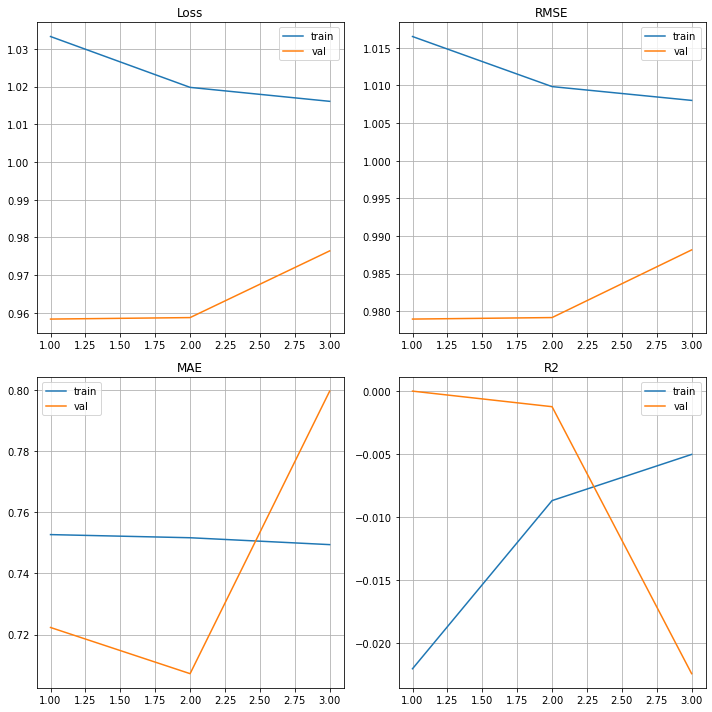

In [24]:
hist = pd.DataFrame(history.history)
x = hist.index+1
fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(x, hist.loss, label="train")
plt.plot(x, hist.val_loss, label="val")
plt.title("Loss")
plt.legend()
plt.grid(True)

plt.subplot(222)
plt.plot(x, hist.root_mean_squared_error, label="train")
plt.plot(x, hist.val_root_mean_squared_error, label="val")
plt.title("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(223)
plt.plot(x, hist.mean_absolute_error, label="train")
plt.plot(x, hist.val_mean_absolute_error, label="val")
plt.title("MAE")
plt.legend()
plt.grid(True)

plt.subplot(224)
plt.plot(x, hist.r_square, label="train")
plt.plot(x, hist.val_r_square, label="val")
plt.title("R2")
plt.legend()
plt.grid(True)
plt.tight_layout()

In [25]:
df_performance.to_csv("./data/df_performance.csv",index_label='Model')

In [26]:
# hist.to_csv("./data/keras_distil_bert_hist.csv", index=False)

In [27]:
# df_temp = df_performance.iloc[-1,:]
# df_temp.to_csv("./data/keras_distil_bert.csv", index_label='Model')

In [28]:
df_per = pd.read_csv("./data/df_performance.csv")
df_per.set_index("Model", inplace=True)
df_per

,Size,Train RMSE,Train MAE,Train R2,Time Elapsed,Valid RMSE,Valid MAE,Valid R2,Valid Elapsed,Test RMSE,Test MAE,Test R2,Test Elapsed
Model,,,,,,,,,,,,,
linreg,7432.0,109958.600000,38663.800000,0.980000,0.0016,143922.300000,51397.7000,0.970000,0.0000,138415.100000,52290.400000,0.97000,0.0000
svc_regr,7579.0,888415.700000,422135.800000,-0.290000,0.0015,881327.000000,428619.1000,-0.310000,0.0000,910742.500000,446665.000000,-0.31000,0.0000
rand_for_reg,24770494.0,67211.800000,20448.700000,0.990000,0.1519,134162.600000,39441.2000,0.970000,0.0616,138995.700000,42581.300000,0.97000,0.0275
ada_boost_reg,36763.0,219145.300000,160038.500000,0.920000,0.0286,221945.000000,161057.6000,0.920000,0.0103,231910.700000,165048.400000,0.91000,0.0040
grd_boost_reg,120991.0,105024.100000,39911.100000,0.980000,0.0120,130199.300000,46705.4000,0.970000,0.0040,131216.300000,48082.800000,0.97000,0.0040
xgb_reg,218927.0,70285.500000,24723.600000,0.990000,0.0087,129252.800000,38749.2000,0.970000,0.0041,132213.000000,40272.000000,0.97000,0.0040
keras_conv1d,6487298.0,781090.300000,594721.100000,0.000000,3.8083,776082.100000,584514.0000,0.000000,1.1968,786705.200000,597160.300000,0.00000,0.3920
keras_conv1d_y_transform,6488956.0,248101.800000,164969.500000,0.900000,4.1894,248354.300000,165562.9000,0.900000,0.9288,245817.800000,165041.100000,0.90000,0.3614
keras_bi_dir_LSTM,10721678.0,173611.800000,77624.400000,0.950000,13.6623,172175.100000,77670.3000,0.950000,3.7964,156272.900000,67821.000000,0.96000,1.6370
